In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from scipy.io import wavfile
from scipy.signal import stft
from sklearn.model_selection import train_test_split

# Directories
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/physionet_challenge_2016"  # Update with your dataset path
NORMAL_DIR = os.path.join(DATASET_DIR, "Normal")
ABNORMAL_DIR = os.path.join(DATASET_DIR, "Abnormal")

# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
PATCH_SIZE = 16
NUM_CLASSES = 1  # Binary classification
EMBED_DIM = 256
NUM_HEADS = 8
FF_DIM = 512
DROPOUT_RATE = 0.3
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-4  # Adjusted learning rate for better convergence

# Helper function to compute spectrogram
def compute_spectrogram(filepath):
    sample_rate, signal = wavfile.read(filepath)
    frequencies, times, spectrogram = stft(signal, fs=sample_rate, nperseg=256)
    spectrogram = np.log(np.abs(spectrogram) + 1e-10)  # Log scale for better feature scaling
    spectrogram = np.resize(spectrogram, (IMG_HEIGHT, IMG_WIDTH))  # Resize to model input size
    return spectrogram

# Load dataset
def load_dataset(normal_dir, abnormal_dir):
    data, labels = [], []

    for filename in os.listdir(normal_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(normal_dir, filename)
            spectrogram = compute_spectrogram(filepath)
            data.append(spectrogram)
            labels.append(0)

    for filename in os.listdir(abnormal_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(abnormal_dir, filename)
            spectrogram = compute_spectrogram(filepath)
            data.append(spectrogram)
            labels.append(1)

    return np.array(data), np.array(labels)

# Load data
print("Loading dataset...")
data, labels = load_dataset(NORMAL_DIR, ABNORMAL_DIR)

# Normalize data
data = data / np.max(data)  # Normalize to range [0, 1]

# Add channel dimension
data = np.expand_dims(data, -1)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Train-test split
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.2, random_state=42)
# Convert labels to float for binary classification
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_val= y_val.astype(np.float32)

# Build ViT Model
def build_vit_model(input_shape, num_patches, embed_dim, num_heads, ff_dim, dropout_rate):
    inputs = layers.Input(shape=input_shape)

    # Feature extraction
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)  # Added Batch Norm
    x = layers.MaxPooling2D((2, 2))(x)
    x = data_augmentation(x)

    # Patch Embedding
    patches = layers.Conv2D(embed_dim, (PATCH_SIZE, PATCH_SIZE), strides=(PATCH_SIZE, PATCH_SIZE), padding="VALID")(x)

    # Compute number of patches
    patch_dim = patches.shape[1] * patches.shape[2]
    embed_dim = patches.shape[-1]
    patches = layers.Reshape((patch_dim, embed_dim))(patches)

    # Positional Encoding
    positions = tf.range(start=0, limit=patch_dim, delta=1)
    positional_encoding = layers.Embedding(input_dim=patch_dim, output_dim=embed_dim)(positions)
    x = patches + positional_encoding

    # Transformer Blocks
    for _ in range(6):
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        attention_output = layers.Dropout(dropout_rate)(attention_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

        # Feedforward Network
        ffn_output = layers.Dense(ff_dim, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(x)
        ffn_output = layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(1e-3))(ffn_output)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Classification Head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

    model = tf.keras.Model(inputs, outputs)
    return model

# Calculate number of patches
num_patches = (IMG_HEIGHT // PATCH_SIZE) * (IMG_WIDTH // PATCH_SIZE)

# Build the model
vit_model = build_vit_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 1),
    num_patches=num_patches,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    dropout_rate=DROPOUT_RATE
)

# Compile the model
optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-4)
vit_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # Binary loss function
    metrics=['accuracy']
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train the model
history = vit_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),  # Use validation_data instead of validation_split
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler]
)


# Evaluate the model
test_loss, test_accuracy = vit_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model_save_path = "/content/drive/MyDrive/pcg_vit_model_sigmoid.keras"
vit_model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Loading dataset...
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.6623 - loss: 4.8319 - val_accuracy: 0.4724 - val_loss: 5.6048 - learning_rate: 1.0000e-04
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.8100 - loss: 4.4442 - val_accuracy: 0.7658 - val_loss: 4.4743 - learning_rate: 1.0000e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.8471 - loss: 4.2606 - val_accuracy: 0.8355 - val_loss: 4.1740 - learning_rate: 1.0000e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.8387 - loss: 4.1396 - val_accuracy: 0.8368 - val_loss: 4.0302 - learning_rate: 1.0000e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.8410 - loss: 4.0049 - val_accuracy: 0.8421 - val_loss: 3.9405 - learning_rate: 1.0000e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.8456 - loss: 3.8579 - val_accuracy: 0.8474 - val_loss: 3.7802 - learning_rate: 1.0000e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step 

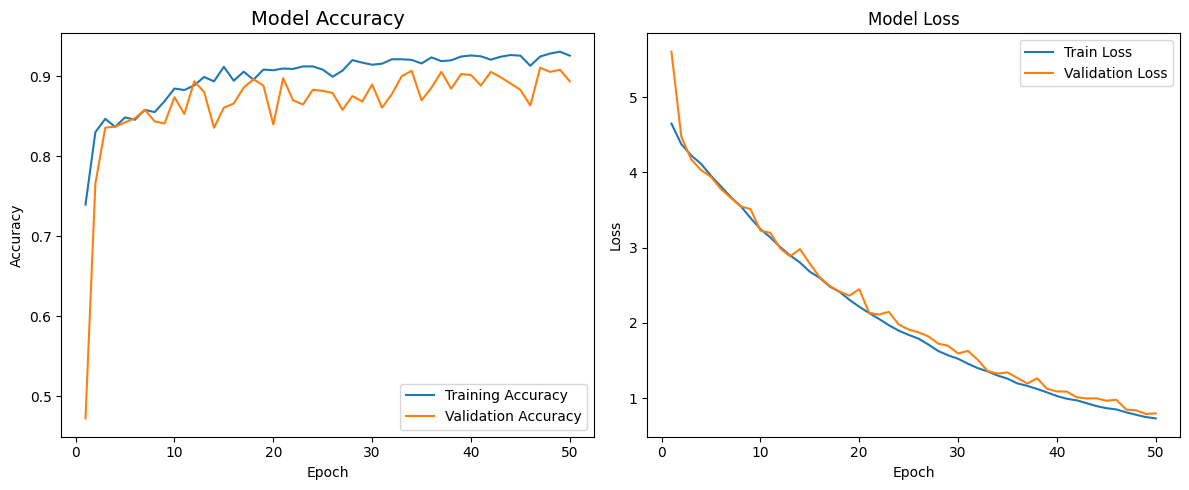

In [ ]:
import matplotlib.pyplot as plt

# Extract data from history
train_accuracy = history.history.get('accuracy', [])
val_accuracy = history.history.get('val_accuracy', [])
train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

epochs = range(1, len(train_accuracy) + 1)

# Plotting model accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting model loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')  # Updated training color
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Set DPI to 300
plt.tight_layout()
plt.savefig('Hybrid_model.png', dpi=300)



In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluate the model
test_loss, test_accuracy = vit_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get predicted probabilities and predicted classes
y_pred_prob = vit_model.predict(x_test)  # Predicted probabilities
y_pred_class = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary class

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_class, target_names=['Normal', 'Abnormal']))





6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.9227 - loss: 0.7817
Test Loss: 0.8139424324035645
Test Accuracy: 0.9105263352394104
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.91      0.92       107
    Abnormal       0.88      0.92      0.90        83

    accuracy                           0.91       190
   macro avg       0.91      0.91      0.91       190
weighted avg       0.91      0.91      0.91       190



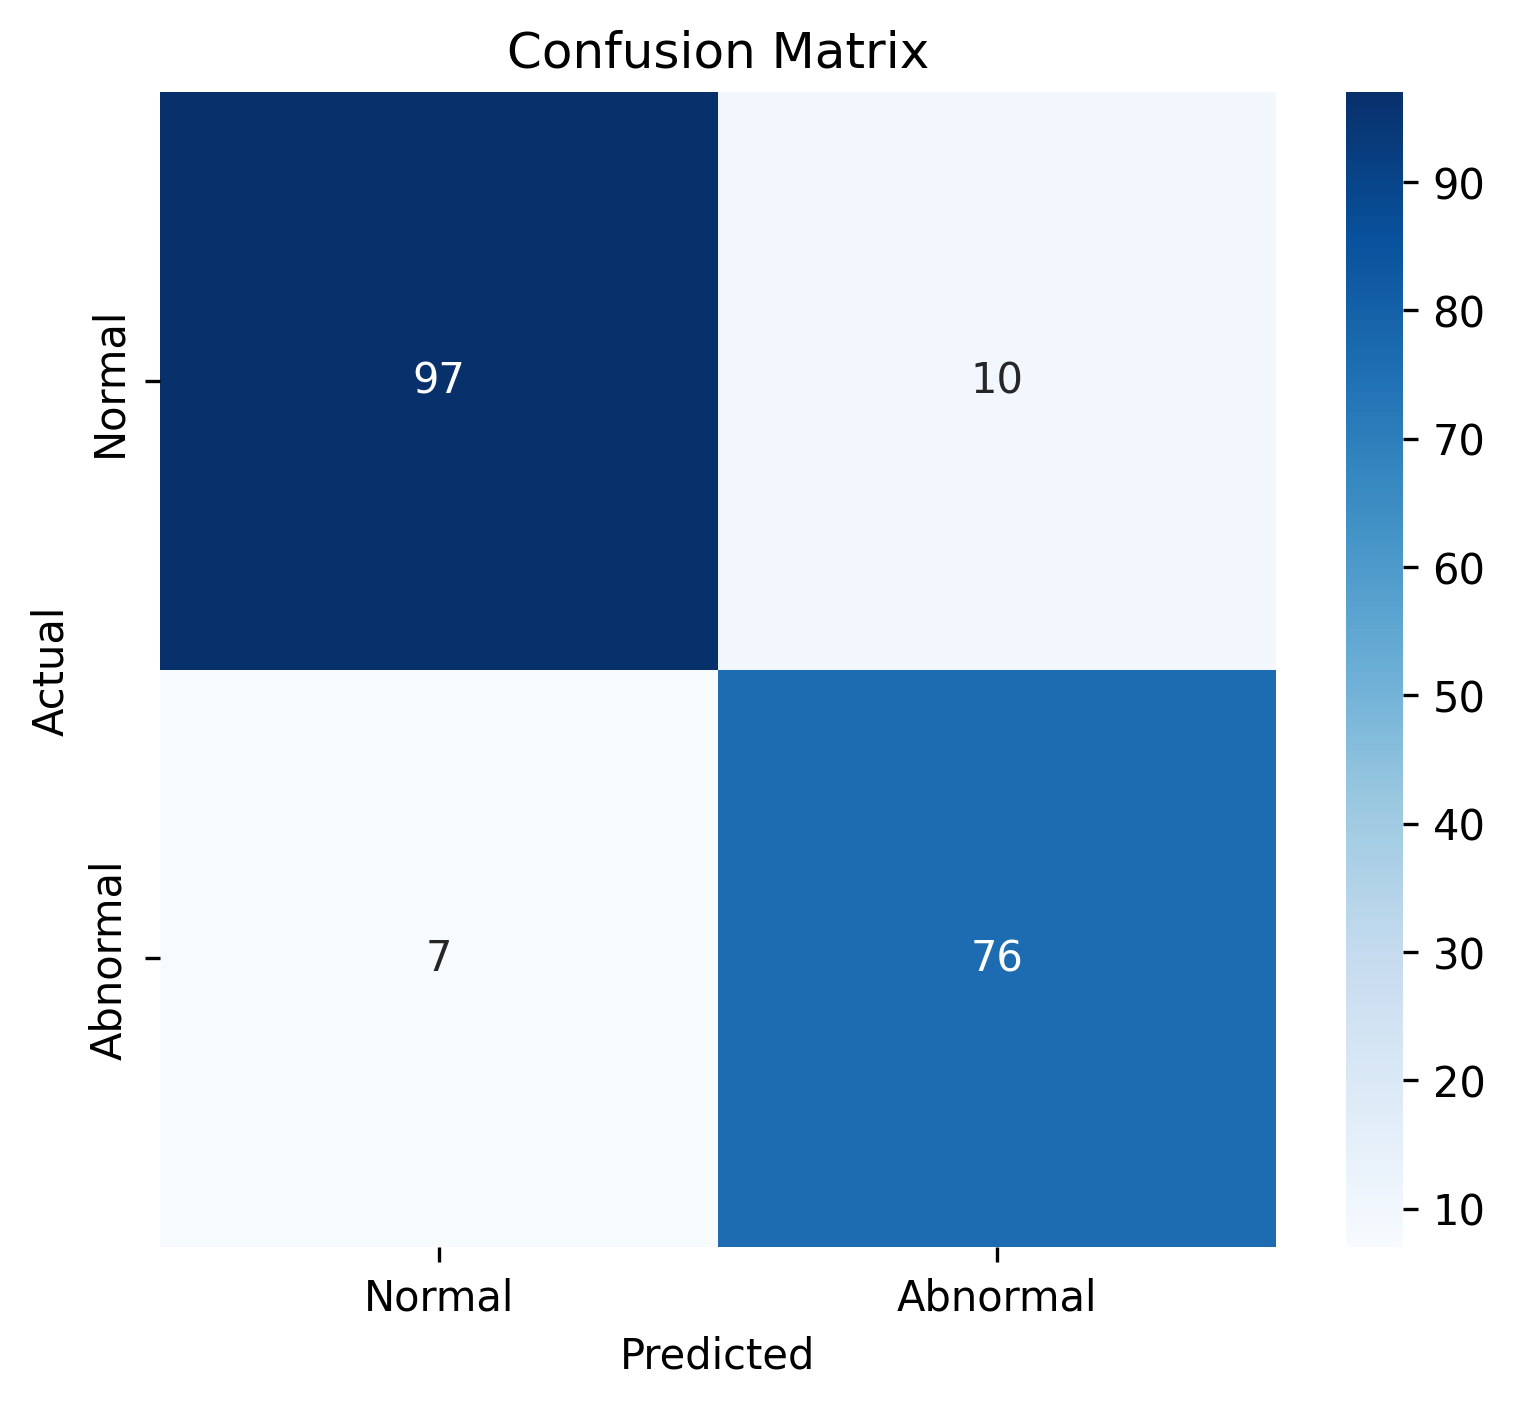

In [ ]:
# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300)  # Save at 300 dpi
plt.show()

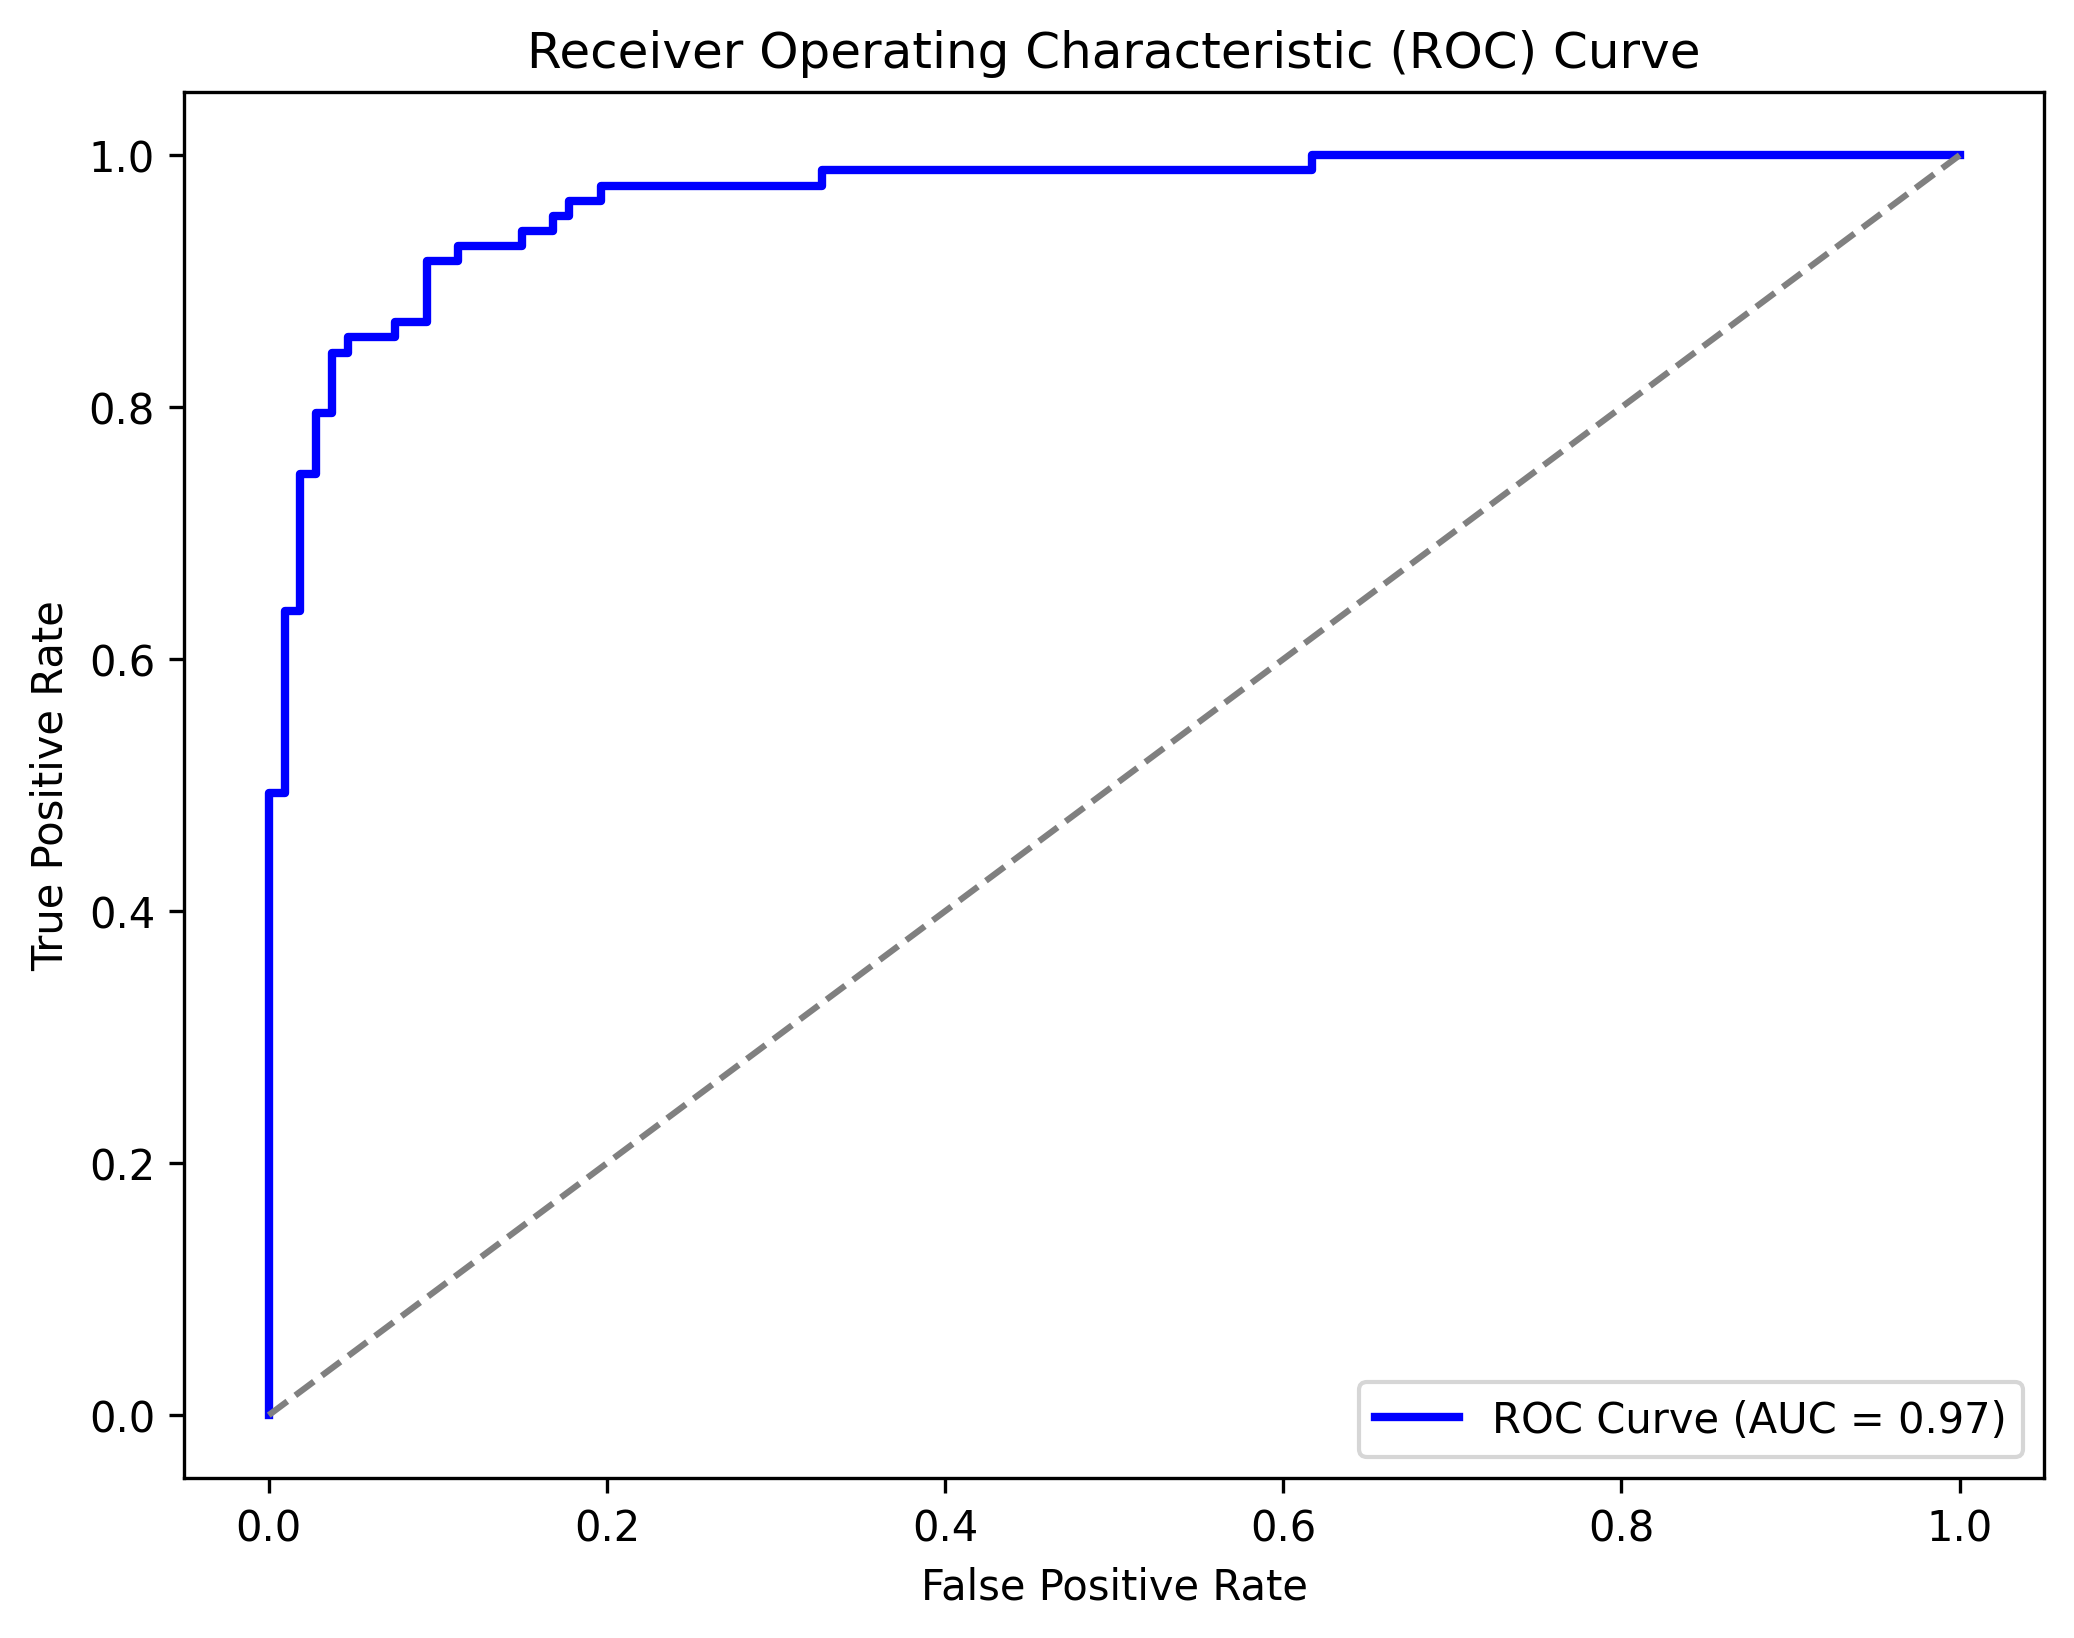

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png", dpi=300)  # Save at 300 dpi
plt.show()
